# TOC
- [Visualize Model Predictions](#vis)
    - [Vesicles](#vis_vesicles)
    - [Nanorods](#vis_nanorods)
- [Model Evaluation](#evaluation)
    - [Average score evaluator](#avg_score_evaluator)
    - [Collect model weight files](#collect_weights)
- [Summarize Evaluation results](#evaluation_summarize)
    - [Summarize Vesicle Evaluations](#evaluation_summarize_vesicle)
    - [Summarize NanoRod Evaluations](#evaluation_summarize_nanorod)
- [Visualize Hyper Parameter effects](#hp_effects)
- refs:
    - good model intro: https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import cv2
import regex as re
from PIL import Image       
import glob
import json
import IPython
from pathlib import Path 
import datetime  
import pickle
import json

import matplotlib.pyplot as plt 
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_test_loader, 
)
from detectron2.evaluation import (
    COCOEvaluator,
    inference_on_dataset,
    DatasetEvaluators,
    verify_results,
)
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
import torch


import data_utils
from helpers_coco import images_annotations_info, create_sub_masks, create_sub_mask_annotation, create_category_annotation, create_image_annotation, create_annotation_format, get_coco_json_format
from helpers_coco import CocoDataset
from helpers_coco import process_img_pixel_annotation
from helpers_coco import list_imgs_in_dir, standardize_color, clean_annotation_mask, remove_noise
from helpers_coco import display_ddicts


### prepare image of enhanced brightness

In [92]:
from PIL import Image,ImageEnhance

# fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_raw/20190405_2.0_kx_micro_1708_0004_ceta.png'
# fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_val/20190405_2.0_kx_micro_1731_0000_ceta.png'
# fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train/20210517 0006 HAADF.tif'
# fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_val/20210517 0012 HAADF.tif'
fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_val/20210517 0002 HAADF.tif'


img=Image.open(fname)
img_brightness_obj=ImageEnhance.Brightness(img)
enhanced_img=img_brightness_obj.enhance(1.5)
# enhanced_img.save(fname[:-4]+'_bright.png')
enhanced_img.save(fname[:-4]+'_bright.tif')


In [34]:
from detectron2.utils.visualizer import Visualizer
def display_ddicts(ddict, outpath=None, dataset='', gt=True, img_path=None,
                   suppress_labels=False, summary=True):
    r"""
    Visualize gt annotations overlaid on the image.

    Displays the image in img_path. Overlays the bounding boxes and segmentation masks of each instance in the image.

    Parameters
    ----------

    ddict: list(dict) or None
        for ground truth- data dict containing masks. The format of ddict is described below in notes.

    outpath: str or path-like object, or None
        If None, figure is displayed with plt.show() and not written to disk
        If string/path, this is the location where figure will be saved to

    dataset: str
        name of dataset, included in filename and figure title.
        The dataset should be registered in both the DatasetCatalog and MetadataCatalog
        for proper plotting. (see detectron2 datasetcatalog for more info.)


    gt: bool
        if True, visualizer.draw_dataset_dict() is used for GROUND TRUTH instances
        if False, visualizer.draw_instance_predictions is used for PREDICTED instances

    img_path: str or path-like object
        if None, img_path is read from ddict (ground truth)
        otherwise, it is a string or path to the image file

    suppress_labels: bool
        if True, class names will not be shown on visualizer

    summary: bool
        If True, prints summary of the ddict to terminal


    Returns
    -------
    None

    Notes
    -----
    The ddict should have the following format:

    .. code-block:: text

        'file_name': str or Path object
            path to image corresponding to annotations
        'mask_format': str
            'polygonmask' if segmentation masks are lists of XY coordinates, or
            'bitmask'  if segmentation masks are RLE encoded segmentation masks
        'height': int
            image height in pixels
        'width': int
            image width in pixels
        'annotations': list(dic)
            list of annotations. See the annotation format below.
        'num_instances': int
            equal to len(annotations)- number of instances present in the image


    The dictionary format for the annotation dictionaries is as follows:

    .. code-block:: text

        'category_id': int
                    numeric class label for the instance.
        'bbox_mode': detectron2.structures.BoxMode object
                describes the format of the bounding box coordinates.
                The default is BoxMode.XYXY_ABS.
        'bbox':  list(int)
            4-element list of bbox coordinates
        'segmentation': list
                    list containing:
                      * a list of polygon coordinates (mask format is polygonmasks)
                      * dictionaries  of RLE mask encodings (mask format is bitmasks)


    """
    if img_path is None:
        img_path = ddict['file_name']
    img_path = Path(img_path)

    if suppress_labels:
        if gt:
            ids = [x['category_id'] for x in ddict['annotations']]
        else:
            ids = ddict['instances'].pred_classes
        u = np.unique(ids)
        metadata = {'thing_classes': ['' for x in u]}
    else:
        metadata = MetadataCatalog.get(dataset)

    visualizer = Visualizer(cv2.imread(str(img_path)), metadata=metadata, scale=1)

    if gt:  # TODO automatically detect gt vs pred?
        vis = visualizer.draw_dataset_dict(ddict)
        n = ddict['num_instances']
    else:
        vis = visualizer.draw_instance_predictions(ddict['instances'])
        n = len(ddict['instances'])

    fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
    ax.imshow(vis.get_image())
    ax.axis('off')
#     ax.set_title('{}\n{}'.format(dataset, img_path.name))
    fig.tight_layout()
    if outpath is not None:
        fig_path = Path(outpath)
        fig.savefig(fig_path, bbox_inches='tight', dpi=500)
    else:
        plt.show()
    plt.close(fig)

    if summary:
        summary_string = 'ddict info:\n\tpath: {}\n\tnum_instances: {}'.format(img_path, n)
        print(summary_string)


In [72]:
res_2.iloc[0]['model_file']

'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/6/output_2/nclasses_2_setting_0/model_final.pth'

# Visualize Model Predictions <a id='vis'></a>

## Vesicles <a id='vis_vesicles'></a>

In [37]:
# ### best of small vesicles
EXPERIMENT_NAME = 'vesicles'
color = '2'
tag = ''   # '_nobackground' | ''
setting_idA = 6
setting_idB = 0
n_classes = 2

res_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/{setting_idA}/output_{color}{tag}/nclasses_{n_classes}_setting_{setting_idB}/'

### best of big vesicles
# EXPERIMENT_NAME = 'vesicles'
# color = '1'
# tag = ''   # '_nobackground' | ''
# setting_idA = 3
# setting_idB = 24
# n_classes = 2
# res_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/{setting_idA}/output_{color}{tag}/nclasses_{n_classes}_setting_{setting_idB}/'
# res_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/3/output_1/nclasses_2_setting_24/'




In [38]:
data_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/'
dataset_train = f"{EXPERIMENT_NAME}_train"
dataset_val = f"{EXPERIMENT_NAME}_val"
train_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_train_coco_{color}{tag}/train.json"
train_img_dir = data_dir + f"/{EXPERIMENT_NAME}_train/"
val_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_val_coco_{color}{tag}/val.json"
val_img_dir = data_dir + f"/{EXPERIMENT_NAME}_val/"

DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times
register_coco_instances(dataset_train, {},
                        train_annotation_file,
                        train_img_dir)
register_coco_instances(dataset_val, {},
                        val_annotation_file,
                        val_img_dir)

print('Registered Datasets: ', list(DatasetCatalog.data.keys()))

Registered Datasets:  ['vesicles_train', 'vesicles_val']


In [39]:
# from detectron2.config import get_cfg
# from detectron2 import model_zoo
# from pathlib import Path
from detectron2.config import CfgNode

### cfg from config.yaml file, small vesicles
cfg = get_cfg() # initialize cfg object
cfg.SOLVER.BEST_CHECKPOINTER = CfgNode({"ENABLED": False})
cfg.SOLVER.BEST_CHECKPOINTER.METRIC = f"{dataset_val}/bbox/AP"
cfg.SOLVER.BEST_CHECKPOINTER.MODE = "max"

try:  # load parameters
    cfg.merge_from_file(res_dir + 'config.yaml')  
except:   # avoid type mismatch error
    cfg.INPUT.MIN_SIZE_TRAIN = []   # maybe number or list
    cfg.merge_from_file(res_dir + 'config.yaml')  
cfg.MODEL.DEVICE = 'cpu'


# ## cfg from scratch, big vesicles
# cfg = get_cfg() # initialize cfg object
# cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
# cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
# cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
# cfg.DATASETS.TEST = (dataset_train, dataset_val, )  # we will look at the predictions on both sets after training
# cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
# cfg.SOLVER.MAX_ITER = 2000  # maximum number of iterations to run during training
# cfg.SOLVER.CHECKPOINT_PERIOD = 400  # number of iterations after which to save model checkpoints
# cfg.MODEL.DEVICE='cpu'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = n_classes # Since we are training separate models for particles and satellites there is only one class output
# cfg.TEST.DETECTIONS_PER_IMAGE = 500   # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
#   # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)


# ### output directory
# # out_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/{EXPERIMENT_NAME}_output_{color}{tag}'

# # out_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/{setting_idA}/output_{color}/nclasses_{n_classes}_setting_{setting_idB}/'
# # print('Is dir: ', os.path.isdir(out_dir))
# # print(out_dir)

# # cfg.OUTPUT_DIR = str(out_dir)


In [40]:
# cfg.MODEL.WEIGHTS = res_1.iloc[-3]['model_file']
cfg.MODEL.WEIGHTS = res_dir + 'model_final.pth'

predictor = DefaultPredictor(cfg)  # create predictor object

# print(model_checkpoints[-1])

--- 2.4299099445343018 seconds ---


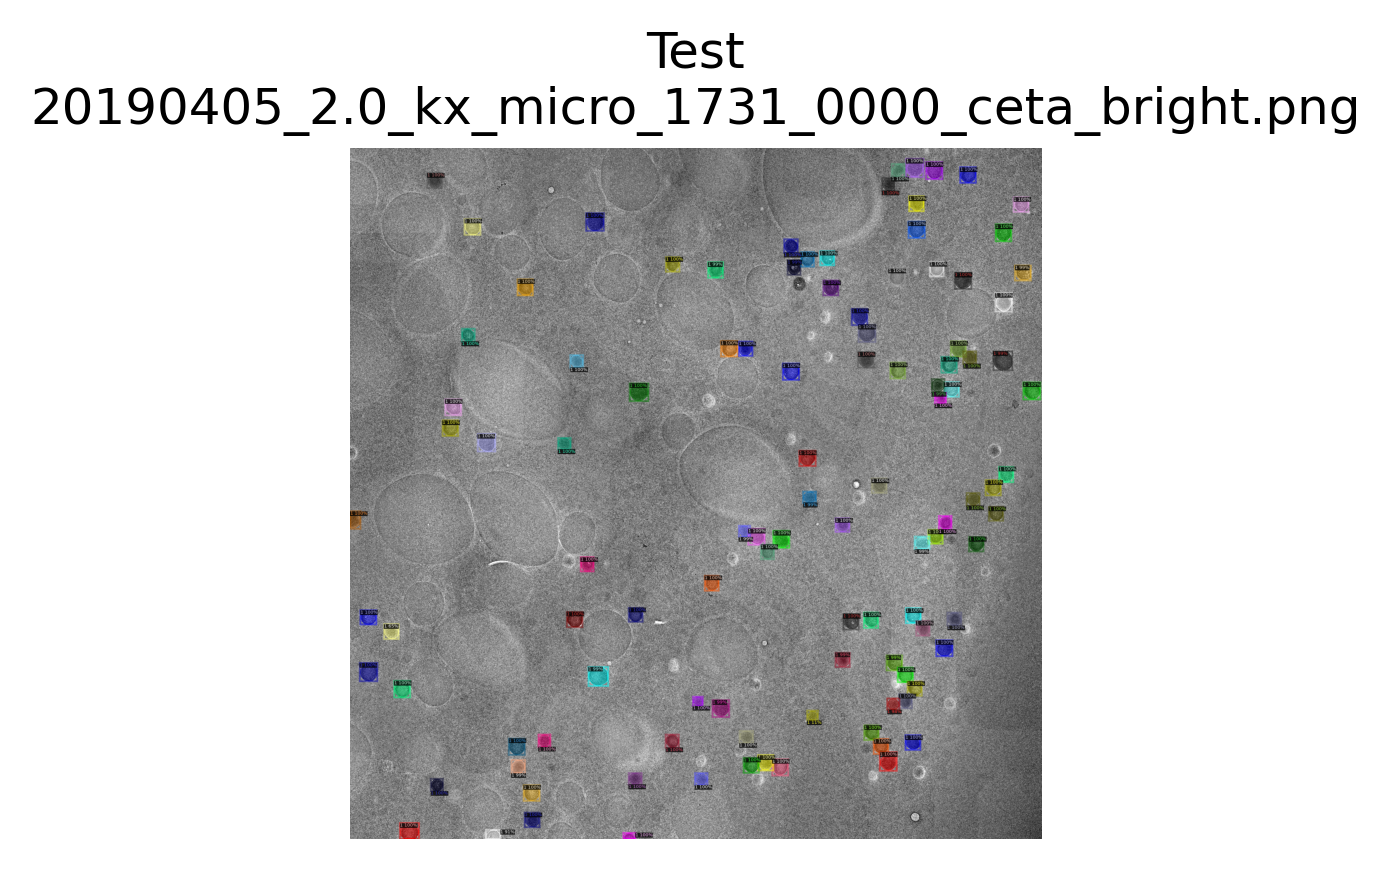

ddict info:
	path: /usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_val/20190405_2.0_kx_micro_1731_0000_ceta_bright.png
	num_instances: 108


In [43]:
img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_val/20190405_2.0_kx_micro_1731_0000_ceta_bright.png'
# img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train/20190405_2.0_kx_micro_1708_0004_ceta.png'

import time 
start_time = time.time()

img = cv2.imread(img_file)
outs = predictor(img)
print("--- %s seconds ---" % (time.time() - start_time))

# data_utils.format_outputs(img_file, dataset='test', pred=outs)
display_ddicts(ddict=outs,  # predictions to display
                outpath=None, dataset='Test',  # don't save figure
                gt=False,  # specifies format as model predictions
                img_path=img_file)  # path to image





In [80]:
with open('vesicle_class2_20190405_2.0_kx_micro_1731_0000_ceta.pkl', 'wb') as f:
    pickle.dump(outs, f)
# with open('vesicle_class1_20190405_2.0_kx_micro_1731_0000_ceta.pkl', 'rb') as f:
#     a = pickle.load(f)
# outs['instances']

## Nanorods <a id='vis_nanorods'></a>

In [16]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from helpers_coco import myVisualizer


EXPERIMENT_NAME = 'nanorods'

data_dir =  '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/'
dataset_train = f"{EXPERIMENT_NAME}_train"
dataset_val = f"{EXPERIMENT_NAME}_val"
train_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_train_2classes_coco/train.json"
train_img_dir = data_dir + f"/{EXPERIMENT_NAME}_train/"
val_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_val_2classes_coco/val.json"
val_img_dir = data_dir + f"/{EXPERIMENT_NAME}_val/"

DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times
register_coco_instances(dataset_train, {},
                        train_annotation_file,
                        train_img_dir)
register_coco_instances(dataset_val, {},
                        val_annotation_file,
                        val_img_dir)


In [82]:
res_2classes.iloc[2]['model_file']

'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/8/output_2classes/setting_8/model_final.pth'

In [11]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import transforms as T

def my_transform_instance_annotations(annotation, transforms, image_size, *, keypoint_hflip_indices=None):
    if annotation["bbox_mode"] == BoxMode.XYWHA_ABS:
        annotation["bbox"] = transforms.apply_rotated_box(np.asarray([annotation["bbox"]]))[0]
    else:
        bbox = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
        # Note that bbox is 1d (per-instance bounding box)
        annotation["bbox"] = transforms.apply_box([bbox])[0]
        annotation["bbox_mode"] = BoxMode.XYXY_ABS

    return annotation

def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with our own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    image, transforms = T.apply_transform_gens([T.Resize((800, 800))], image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
      my_transform_instance_annotations(obj, transforms, image.shape[:2]) 
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances_rotated(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluators = [RotatedCOCOEvaluator(dataset_name, cfg, True, output_folder)]
        return DatasetEvaluators(evaluators)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)

class RotatedPredictor(DefaultPredictor):
    def __init__(self, cfg):
        
        self.cfg = cfg.clone()  # cfg can be modified by model
        trainer = MyTrainer(self.cfg) 
        trainer.resume_or_load(resume=False)   # resume:https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.defaults.DefaultTrainer.resume_or_load
        self.model = trainer.model
        self.model.eval()

        self.transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
#             height, width = original_image.shape[:2]
#             image = self.transform_gen.get_transform(original_image).apply_image(original_image)
            image, transforms = T.apply_transform_gens([T.Resize((800, 800))], original_image)
            height = 800
            width = 800
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions





In [17]:
# model_weights = res_2classes.iloc[2]['model_file']
model_weights = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/8/output_2classes/setting_8/model_final.pth'
cfg_file = '/'.join(model_weights.split('/')[:-1]) + '/config.yaml'

cfg = get_cfg()
cfg.INPUT.MIN_SIZE_TRAIN = 2000  # avoid type mismatch
cfg.merge_from_file(cfg_file)
cfg.MODEL.WEIGHTS = model_weights
cfg.MODEL.DEVICE = 'cpu'

predictor = RotatedPredictor(cfg)
# predictor = DefaultPredictor(cfg)


[02/20 20:01:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output4): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): Group

[02/20 20:01:03 d2.data.datasets.coco]: Loaded 19 images in COCO format from /usr/workspace/zhong2/Research/FeedOpt/Questek/Data//nanorods_train_2classes_coco/train.json
[02/20 20:01:03 d2.data.build]: Removed 0 images with no usable annotations. 19 images left.
[02/20 20:01:03 d2.data.build]: Using training sampler TrainingSampler
[02/20 20:01:03 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[02/20 20:01:03 d2.data.common]: Serialized dataset takes 0.09 MiB


In [93]:
from detectron2.structures import RotatedBoxes
from copy import deepcopy

# img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train/20210517 0006 HAADF.tif'
# img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_val/20210517 0012 HAADF.tif'

# check = 'train'
# img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train/20210517 0006 HAADF_bright.tif'
# check = 'val_0012'
# img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_val/20210517 0012 HAADF_bright.tif'
check = 'val_0002'
img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_val/20210517 0002 HAADF_bright.tif'

im = cv2.imread(img_file)
# resized = cv2.resize(im, [800, 800], interpolation = cv2.INTER_AREA)


with open(f'nanorods_{check}.pkl', 'rb') as f:
    outputs = pickle.load(f)

### default predictor does not scale input to (800, 800), which results in incorrect predictions
# outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

### correct predictions by running pred_img.py, but needs to scale back mannually
pred_boxes = deepcopy(outputs.pred_boxes.tensor.detach().numpy())
pred_boxes[:, :4] = pred_boxes[:, :4] / 800 * 4096 
outputs.pred_boxes = RotatedBoxes(torch.from_numpy(pred_boxes))


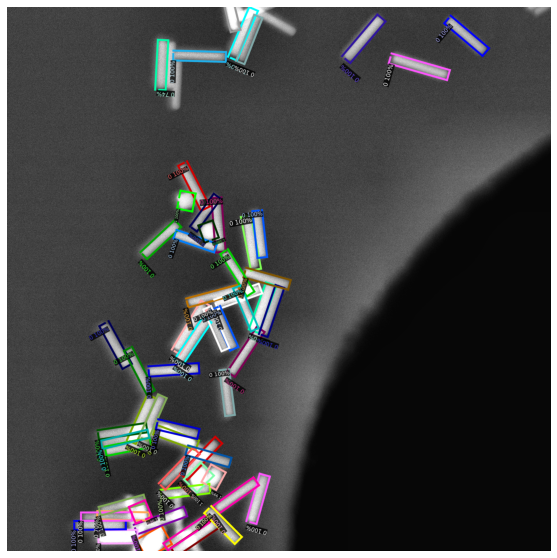

In [94]:
v = myVisualizer(im[:, :, ::-1],
              metadata=MetadataCatalog.get(dataset_val), 
              scale=0.5)
              # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
# )
# out = v.draw_instance_predictions(outputs["instances"])
out = v.draw_instance_predictions(outputs)

plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.savefig(f'nanorods_{check}.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
import json
fname = '../Results/Tuning_nanorods/8/output_2classes/setting_8/model_final_output_train/coco_instances_results.json'

with open(fname) as f:
    outputs_all = json.load(f)
outputs_all



[{'image_id': 0,
  'category_id': 1,
  'bbox': [1796.2142333984375,
   1962.179443359375,
   69.64531707763672,
   377.7141418457031,
   68.04757690429688],
  'score': 0.9999979734420776},
 {'image_id': 0,
  'category_id': 1,
  'bbox': [1655.83447265625,
   2742.462646484375,
   63.82959747314453,
   362.1648864746094,
   106.3193359375],
  'score': 0.9999961853027344},
 {'image_id': 0,
  'category_id': 1,
  'bbox': [1481.648193359375,
   2675.55615234375,
   70.37712097167969,
   376.3172912597656,
   160.92318725585938],
  'score': 0.9999957084655762},
 {'image_id': 0,
  'category_id': 1,
  'bbox': [2102.288818359375,
   1981.6141357421875,
   70.61998748779297,
   356.7514953613281,
   79.98562622070312],
  'score': 0.9999946355819702},
 {'image_id': 0,
  'category_id': 1,
  'bbox': [1997.291015625,
   2541.701904296875,
   76.97606658935547,
   348.45574951171875,
   8.134979248046875],
  'score': 0.999992847442627},
 {'image_id': 0,
  'category_id': 1,
  'bbox': [2135.1259765625,


# Model Evaluation <a id='evaluation'></a>
- Common instance segmentation metrics
    - Instance segmentation: AP, AP50, AP75, mAP, AP@[0.5:0.95]
    - Note that the precision-recall curve is about how many predicted boxes to keep (some predicted boxes may overlap) so it is natural. 
    - IoU threshold is about determining True / False predictions regardless of the #boxes threshold. 
    - refs:
        - https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
        - https://yanfengliux.medium.com/the-confusing-metrics-of-ap-and-map-for-object-detection-3113ba0386ef
        - https://www.jeremyjordan.me/evaluating-image-segmentation-models/
        - Scematic segmentation metrics: IoU, averge IoU, pixel accuracy
       
- Holm group paer
    - Using one single IoU (0.5), and defined recall and precision separately for detection & segmentation. 
    - Using one single IoU is not good, and using one single precision / recall value is also not good. But is more intuitive. 
- Coding evaluation
    - https://ortegatron.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
    - https://github.com/facebookresearch/detectron2/blob/c152862a18182544b9f41dac0519e87c5ff8ac6c/projects/PointRend/train_net.py#L102-L108

In [ ]:
# cfg_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/0/output_3/nclasses_2_setting_2/config.yaml'
# model_weights = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/3/output_1/nclasses_1_setting_20/model_0001999.pth'

# cfg = get_cfg()
# cfg.SOLVER.BEST_CHECKPOINTER
# cfg.merge_from_file(cfg_file)
# cfg.MODEL.WEIGHTS = model_weights
# cfg.MODEL.DEVICE = 'cpu'


In [1]:
# predictor = DefaultPredictor(cfg)

# val_loader = build_detection_test_loader(cfg, dataset_val)
# evaluator = COCOEvaluator(dataset_val, output_dir="./output")
# inference_on_dataset(predictor.model, val_loader, evaluator)

### Average score evaluator<a id='avg_score_evaluator'></a>

In [32]:
class AvgScoreEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name, output_dir=None):
        self._output_dir = output_dir
        
    def reset(self):
        self.avg_score = 0
    def process(self, inputs, outputs):
        tmp = []
        for output in outputs:
            tmp += output["instances"].scores
        self.avg_score =np.mean(tmp)
    def evaluate(self):
        # save self.count somewhere, or print it, or return it.
        return {"avg_score": self.avg_score}
    
    
val_loader = build_detection_test_loader(cfg, dataset_val)
evaluator = AvgScoreEvaluator(dataset_val, output_dir="./output")
inference_on_dataset(predictor.model, val_loader, evaluator)

{'avg_score': 0.97933024}

In [37]:
out_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/3/output_1/nclasses_1_setting_20/model_0001999_output_val/'
coco_instances_file = out_dir + 'coco_instances_results.json'
predictions_file = out_dir + 'instances_predictions.pth'

with open(coco_instances_file, 'r') as f:
    coco_instances = json.load(f)

predictions =  torch.load(predictions_file)

cnt = 0
score = 0.0
for pred in coco_instances:
    score += pred['score']
    cnt += 1
print(score / cnt)


0.9991455596117746


In [86]:
# %load_ext tensorboard
# os.environ['TENSORBOARD_BINARY'] = '/usr/workspace/zhong2/anaconda3/envs/segmentation/bin/tensorboard'
# %tensorboard --logdir '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/vesicles_output_2_good/'

In [92]:
file_2_good = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/vesicles_output_1_good/metrics.json'
# val_annotation_file
with open(file_2_good, 'r') as f:
    metrics_2_good = [json.loads(line) for line in f]

file_all_bad = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/vesicles_output_1_good/metrics.json'
# val_annotation_file
with open(file_all_bad, 'r') as f:
    metrics_all_bad = [json.loads(line) for line in f]

metrics_2_good[0].keys()

dict_keys(['data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy', 'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'iteration', 'loss_box_reg', 'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'mask_rcnn/accuracy', 'mask_rcnn/false_negative', 'mask_rcnn/false_positive', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors', 'time', 'total_loss'])

### Collect model weight files <a id='collect_weights'></a>

In [7]:
import os
import pickle


# def update_if_model_file(model_weight_files, res_dir, file):
#     """ model_files is a list storing all model weights to check """
#     return model_weight_files
experiment_name = 'vesicles'  # 'vesicles' | 'nanorods'

### Prepare models to eval
root_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_{experiment_name}/'
model_weight_files = []
# for tmp_1 in os.listdir(root_dir):
for tmp_1 in ['7', '8']:
    sub_dir_1 = root_dir + tmp_1 + '/'
#     print(tmp_1, sub_dir_1)
    if os.path.isdir(sub_dir_1):
        for tmp_2 in os.listdir(sub_dir_1):
            sub_dir_2 = sub_dir_1 + tmp_2 + '/'
            if os.path.isdir(sub_dir_2):
                for tmp_3 in os.listdir(sub_dir_2):
                    sub_dir_3 = sub_dir_2 + tmp_3 + '/'
                    if os.path.isdir(sub_dir_3):
                        for file in os.listdir(sub_dir_3):
                            if file[:5] == 'model' and file[-4:] == '.pth':
                                coco_file = file.split('.')[0] + '_coco_metrics.json'
                                if os.path.exists(sub_dir_3  + coco_file): ### append only new models
                                    continue
                                else:
                                    model_weight_files.append(sub_dir_3 + file)
            
print(len(model_weight_files))

0


In [6]:
res_dir = root_dir + 'model_weight_files_7-8/'
os.makedirs(res_dir, exist_ok=True)
n_files = 1
n = int(len(model_weight_files) / n_files)
for i in range(n_files):
    fname = res_dir + f'model_weights_{i+4}.pkl'
    with open(fname, 'wb') as f:
        start = i * n
        end = min((i + 1) * n, len(model_weight_files))
        pickle.dump(model_weight_files[start:end], f)
        
print(fname)
        

/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/model_weight_files_7-8/model_weights_4.pkl


In [3]:
fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/2/settings_2.pkl'
with open(fname, 'rb') as f:
    setting_2 = pickle.load(f)
    
fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/3/settings_3.pkl'
with open(fname, 'rb') as f:
    setting_3 = pickle.load(f)
    
setting_3

78

# Summarize Evaluation results <a id='evaluation_summarize'></a>
## Summarize Vesicle Evaluations <a id='evaluation_summarize_vesicle'></a>

In [6]:
import regex as re
import pickle
import pandas as  pd


### prepare columns of result & check all settings 
EXPERIMENT_NAME = 'vesicles'
root_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_{EXPERIMENT_NAME}/'
# settings_check = ['6']
settings_check = ['1', '2', '3', '4', '5']
hps = set()
# for idx_settings in os.listdir(root_dir):
#     if idx_settings.isdigit():
for idx_settings in settings_check:
    settings_file = root_dir + idx_settings + '/' + f'settings_{idx_settings}.pkl'
    with open(settings_file, 'rb') as f:
        settings = pickle.load(f)
    hps.update(settings[0].keys())
hps = list(hps)

res_metrics = [f'{EXPERIMENT_NAME}_train/bbox/AP', f'{EXPERIMENT_NAME}_train/segm/AP', 
               f'{EXPERIMENT_NAME}_val/bbox/AP', f'{EXPERIMENT_NAME}_val/segm/AP']

cols = ['setting_idA', 'setting_idB', 'color', 'n_classes', 'model_id', 'model_file']
cols.extend(hps)
cols.extend(res_metrics)
res = pd.DataFrame(columns=cols, dtype=float)
res = res.astype({'setting_idA': 'int32', 'setting_idB': 'int32', 'color': 'string', 'n_classes':  'int32', })


### check all results 
idx = 0
# for tmp_1 in os.listdir(root_dir):
# for tmp_1 in ['2']:
for tmp_1 in settings_check:
    sub_dir_1 = root_dir + tmp_1 + '/'
    try:
        settings_file = sub_dir_1 + f'settings_{tmp_1}.pkl'
        with open(settings_file, 'rb') as f:
            settings = pickle.load(f)
        settings_idA = eval(tmp_1)
    except:
        print('NO settings file : ', settings_file)
        continue
    if os.path.isdir(sub_dir_1):
        for tmp_2 in os.listdir(sub_dir_1):
#         for tmp_2 in ['output_3']:
            sub_dir_2 = sub_dir_1 + tmp_2 + '/'
            if os.path.isdir(sub_dir_2):
                for tmp_3 in os.listdir(sub_dir_2):
                    sub_dir_3 = sub_dir_2 + tmp_3 + '/'
                    if os.path.isdir(sub_dir_3):
                        for file in os.listdir(sub_dir_3):
                            if len(file) > 20 and file[-18:] == '_coco_metrics.json':
#                                 print(sub_dir_3+file)

                                ### experiment id
                                settings_idB = eval(tmp_3.split('_')[-1])
                                color = tmp_2.split('_')[1]
                                model_id = file.split('_')[1]
                                n_classes = tmp_3.split('_')[1]
                                model_file = sub_dir_3 + file[:-18] + '.pth'
                                row = [settings_idA, settings_idB, color, n_classes, model_id, model_file]
                                
                                ### hps
                                setting = settings[settings_idB]
                                setting_tmp = []
                                for hp in hps:
                                    setting_tmp.append(setting[hp])
                                row.extend(setting_tmp)
                                
                                ### results
                                try: ### some coco_metrics contain only nan
                                    with open(sub_dir_3 + file, 'rb') as f:
                                        res_setting = json.load(f)
                                    res_tmp = []
                                    for metric in res_metrics:
                                        keys = metric.split('/')
                                        res_metric = res_setting[keys[0] + f'_{color}'][keys[1]][keys[2]]
                                        res_tmp.append(res_metric)
                                    row.extend(res_tmp)

                                    ### append to res
                                    res.loc[idx] = row
                                    idx += 1
                                except:
                                    continue

if 'steps' in hps:
    res['step_size'] = res['steps'].apply(lambda x: x[0])

### separate res
res_1 = res[res['color'] == '1']
res_2 = res[res['color'] == '2']
res_3 = res[res['color'] == '3']
res_all = res[res['color'] == 'all']

res_1 = res_1.sort_values('vesicles_val/bbox/AP', ascending=False)
res_2 = res_2.sort_values('vesicles_val/bbox/AP', ascending=False)
res_3 = res_3.sort_values('vesicles_val/bbox/AP', ascending=False)
res_all = res_all.sort_values('vesicles_val/bbox/AP', ascending=False)


In [11]:
res_1.iloc[0]['model_file']

'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/3/output_1/nclasses_2_setting_24/model_final.pth'

## Summarize NanoRod Evaluations <a id='evaluation_summarize_nanorod'></a>

In [3]:
### prepare columns of result & check all settings 
EXPERIMENT_NAME = 'nanorods'
# settings_check = ['1', '2', '3', '4', '5', '6']
settings_check = ['7', '8']
root_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_{EXPERIMENT_NAME}/'
hps = set()
for idx_settings in os.listdir(root_dir):
    if idx_settings in settings_check:
        if idx_settings.isdigit():
            settings_file = root_dir + idx_settings + '/' + f'settings_{idx_settings}.pkl'
            with open(settings_file, 'rb') as f:
                settings = pickle.load(f)
            hps.update(settings[0].keys())
hps = list(hps)
# hps = [ 'gamma',
#          'imgs_per_batch',
#          'base_lr',
#          'nestrov',
#          'box_reg_weights',
#          'steps',
#         ]

res_metrics = [f'{EXPERIMENT_NAME}_train/bbox/AP', f'{EXPERIMENT_NAME}_val/bbox/AP']

cols = ['setting_idA', 'setting_idB', 'tag', 'model_id', 'model_file']
cols.extend(hps)
cols.extend(res_metrics)
res = pd.DataFrame(columns=cols, dtype=float)
res = res.astype({'setting_idA': 'int32', 'setting_idB': 'int32', 'tag': 'string'})


### check all results 
idx = 0
for tmp_1 in os.listdir(root_dir):
# for tmp_1 in settings_check:
    if tmp_1  in settings_check:
        sub_dir_1 = root_dir + tmp_1 + '/'
        try:
            settings_file = sub_dir_1 + f'settings_{tmp_1}.pkl'
            with open(settings_file, 'rb') as f:
                settings = pickle.load(f)
            settings_idA = eval(tmp_1)
        except:
            print('NO settings file : ', settings_file)
            continue
        if os.path.isdir(sub_dir_1):
            for tmp_2 in os.listdir(sub_dir_1):
    #         for tmp_2 in ['output_3']:
                sub_dir_2 = sub_dir_1 + tmp_2 + '/'
                if os.path.isdir(sub_dir_2):
                    for tmp_3 in os.listdir(sub_dir_2):
                        sub_dir_3 = sub_dir_2 + tmp_3 + '/'
                        if os.path.isdir(sub_dir_3):
                            for file in os.listdir(sub_dir_3):
                                if len(file) > 20 and file[-18:] == '_coco_metrics.json':
    #                                 print(sub_dir_3+file)

                                    ### experiment id
                                    settings_idB = eval(tmp_3.split('_')[-1])
                                    tag = tmp_2.split('_')[1]
                                    model_id = file.split('_')[1]
                                    model_file = sub_dir_3 + file[:-18] + '.pth'
                                    row = [settings_idA, settings_idB, tag, model_id, model_file]

                                    ### hps
                                    setting = settings[settings_idB]
                                    setting_tmp = []
                                    for hp in hps:
                                        setting_tmp.append(setting[hp])
                                    row.extend(setting_tmp)

                                    ### results
                                    try: ### some coco_metrics contain only nan
                                        with open(sub_dir_3 + file, 'rb') as f:
                                            res_setting = json.load(f)
                                        res_tmp = []
                                        for metric in res_metrics:
                                            keys = metric.split('/')
                                            res_metric = res_setting[keys[0] + f'_{tag}'][keys[1]][keys[2]]
                                            res_tmp.append(res_metric)
                                        row.extend(res_tmp)

                                        ### append to res
                                        res.loc[idx] = row
                                        idx += 1
                                    except:
                                        continue

if 'step_size' in hps:
    res['step_size'] = res['steps'].apply(lambda x: x[0])
if (EXPERIMENT_NAME == 'nanorods') and ('rpn_box_reg_weights' in hps):
    res['rpn_angle_weight'] = res['rpn_box_reg_weights'].apply(lambda x: x[4])
if (EXPERIMENT_NAME == 'nanorods') and ('roi_head_box_reg_weights' in hps):
    res['roi_head_angle_weight'] = res['roi_head_box_reg_weights'].apply(lambda x: x[4])
                                    
### separate res
res_normal = res[res['tag'] == '']
res_2classes = res[res['tag'] == '2classes']
res_noOverlap = res[res['tag'] == 'noOverlap']

res_normal = res_normal.sort_values('nanorods_val/bbox/AP', ascending=False)
res_2classes = res_2classes.sort_values('nanorods_val/bbox/AP', ascending=False)
res_noOverlap = res_noOverlap.sort_values('nanorods_val/bbox/AP', ascending=False)

# # res_1 = pd.DataFrame()

'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/8/output_2classes/setting_8/model_final.pth'

In [25]:
model_weight_list = [res_2classes.iloc[2]['model_file']]

with open('tmp.pkl', 'wb') as f:
    pickle.dump(model_weight_list, f)
    
    
    
# with open('tmp.pkl', 'rb') as f:
#     a = pickle.load(f)
# len(a)

([<matplotlib.axis.XTick at 0x2aaae32e0490>,
 [Text(0, 0, 'train'), Text(0, 0, 'test')])

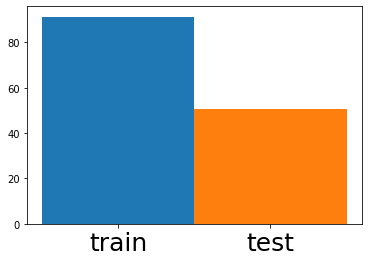

In [33]:
barlist = plt.bar([0, 1], [91.367899, 50.512289], width=1)
barlist[1].set_color(u'#ff7f0e')
plt.xticks([0, 1], labels=['train', 'test'], fontsize=25)
plt.yticks(np.arange(, labels=['train', 'test'], fontsize=25)
# plt.xlabels()

# Visualize Hyper Parameter effects<a id='hp_effects'></a>
- HPs
    - learning rate > 0.02 is good. may need to tune warm start.
    - steps = 2000 is good
    - gamma = 0.9 is good
    - imgs_per_batch = 4
    - nestrov = 1 good, but may be much slower
- Performance Metrics
    - outs['instances'].scores is good metric. 
        - Neither COCO_metrics nor is total_loss good metric. 
            - Example: 1_good - '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/0/output_1/nclasses_2_setting_1/model_0000999.pth'
            - Example: 1_bad - '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_vesicles/3/output_1/nclasses_1_setting_20/model_0001999.pth'

In [66]:
hps = ['base_lr', 'steps', 'gamma', 'imgs_per_batch', 'nestrov']
res = res_1
tag = ''
# res = res_2classes
# tag = '_settings7-8'

def plot_res_for_setting(res, setting_name, tag='', n_bins=8, width=None):
    experiment_name = 'vesicles'
#     experiment_name = 'nanorods'
    save_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_summary/'
    vals = sorted(res[setting_name].unique())
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    if len(vals) < 10:
        if not width:
            width = 0.5
        for val in vals:
            to_plot = res[res[setting_name] == val]
            axes[0].boxplot(to_plot[f'{experiment_name}_train/bbox/AP'], positions=[val], widths=width)
            axes[1].boxplot(to_plot[f'{experiment_name}_val/bbox/AP'], positions=[val], widths=width)
    else:
        intervals = pd.qcut(vals, n_bins).categories
        if np.abs(intervals[0].left) < 0.1 and np.abs(intervals[0].right) < 0.1:
            scale = 10 ** np.floor(- np.log10(min(np.abs(intervals[0].left), np.abs(intervals[0].right))))
        else:
            scale = 1
        
        if not width:
            width = (intervals[-1].left - intervals[-1].right) / 4 * scale
        for interval in intervals:
            to_plot = res[(res[setting_name] > interval.left) & (res[setting_name] <= interval.right)]
            pos = np.round((interval.left + interval.right) / 2 * scale, 2)
#             width = (interval.left - interval.right) * 300
#             print(interval, pos, width)
            axes[0].boxplot(to_plot[f'{experiment_name}_train/bbox/AP'], positions=[pos], widths=width)
            axes[1].boxplot(to_plot[f'{experiment_name}_val/bbox/AP'], positions=[pos], widths=width)

#     axes[0].set_xscale('log')
#     axes[1].set_xscale('log')
    axes[0].set_title('Train', fontsize=20)
    axes[1].set_title('Val', fontsize=20)
    fig.suptitle(f'{experiment_name}: {setting_name}', fontsize=20)
    plt.savefig(save_dir + f'{experiment_name}_{setting_name}{tag}.png', bbox_inches='tight', dpi=300)
    
hps

['base_lr', 'steps', 'gamma', 'imgs_per_batch', 'nestrov']

In [67]:
# plot_res_for_setting(res, 'rpn_in_features', tag=tag)
# res['rpn_in_features']

(-0.000896, 0.000186] -0.36 -0.3246
(0.000186, 0.000331] 0.26 -0.04350000000000001
(0.000331, 0.000527] 0.43 -0.0588
(0.000527, 0.00111] 0.82 -0.17490000000000003
(0.00111, 0.00222] 1.67 -0.333
(0.00222, 0.0115] 6.86 -2.784
(0.0115, 0.0217] 16.6 -3.06
(0.0217, 0.0433] 32.5 -6.4799999999999995


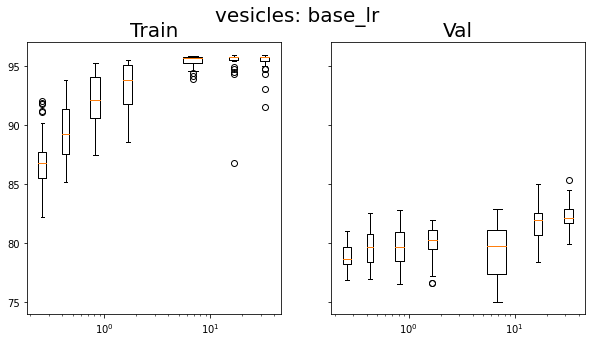

In [68]:
plot_res_for_setting(res, 'base_lr', tag=tag)

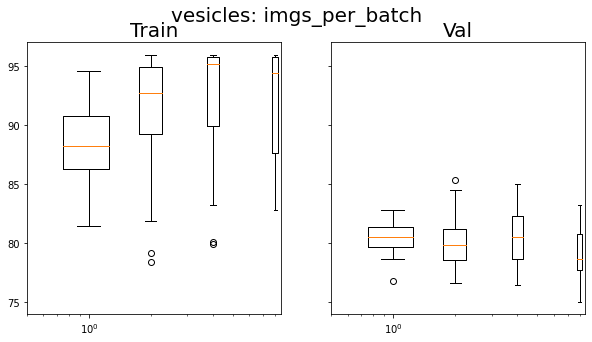

In [55]:
plot_res_for_setting(res, 'imgs_per_batch', tag=tag)

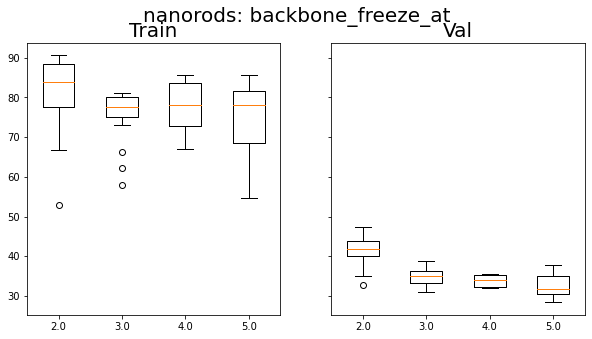

In [34]:
plot_res_for_setting(res, 'backbone_freeze_at', tag=tag)

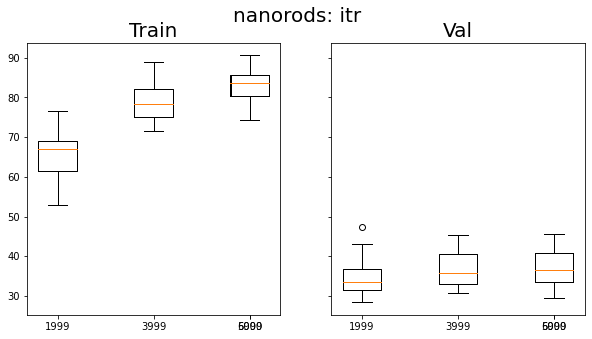

In [36]:
res['itr'] = res['model_id'].apply(lambda x: eval(x.lstrip('0')) if x.isdigit() else 6000)
plot_res_for_setting(res, 'itr', tag=tag, width=800)

(0.116, 0.23] 0.17
(0.23, 0.285] 0.26
(0.285, 0.34] 0.31
(0.34, 0.484] 0.41
(0.484, 0.573] 0.53
(0.573, 0.672] 0.62
(0.672, 0.712] 0.69
(0.712, 0.854] 0.78


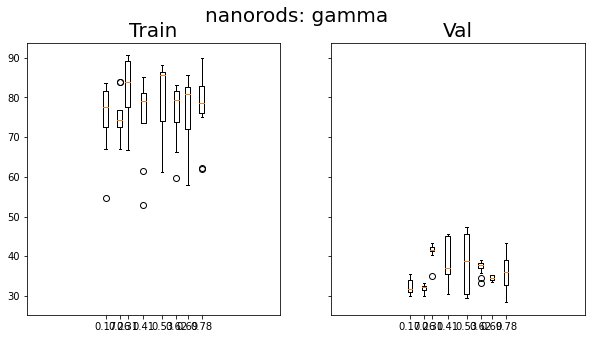

In [37]:
plot_res_for_setting(res, 'gamma', tag=tag, width=0.03)

(1193.999, 1782.5] 1488.25
(1782.5, 2168.5] 1975.5
(2168.5, 2253.125] 2210.81
(2253.125, 2680.5] 2466.81
(2680.5, 3225.5] 2953.0
(3225.5, 4002.75] 3614.12
(4002.75, 4457.75] 4230.25
(4457.75, 4996.0] 4726.88


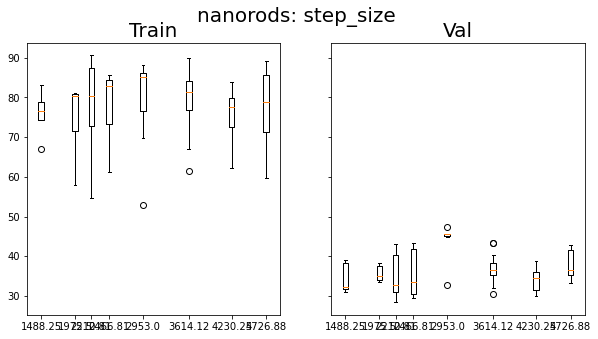

In [38]:
res['step_size'] = res['steps'].apply(lambda x: x[0])
plot_res_for_setting(res, 'step_size', tag=tag, width=80)

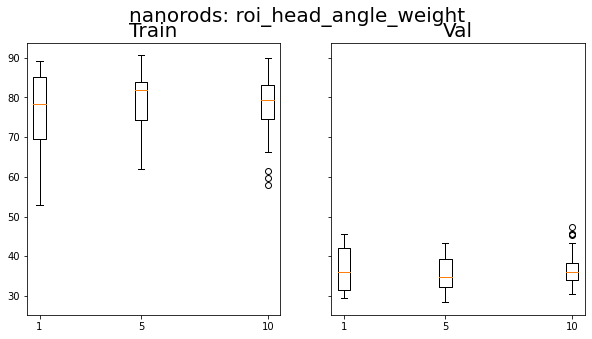

In [41]:
### just for nanorods
plot_res_for_setting(res, 'roi_head_angle_weight', tag=tag)

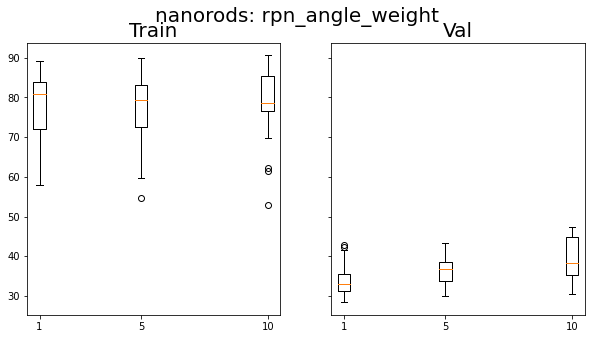

In [42]:
### just for nanorods
plot_res_for_setting(res, 'rpn_angle_weight', tag=tag)

----------------------------------------------------------
Begin at:    01/10/2021 09:07:56


In [3]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import cv2
import regex as re
from PIL import Image       
import glob
import json
import IPython
from pathlib import Path 
import datetime  

import matplotlib.pyplot as plt 
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances


import data_utils
from helpers_coco import images_annotations_info, create_sub_masks, create_sub_mask_annotation, create_category_annotation, create_image_annotation, create_annotation_format, get_coco_json_format
from helpers_coco import CocoDataset
from helpers_coco import process_img_pixel_annotation
from helpers_coco import list_imgs_in_dir, standardize_color, clean_annotation_mask, remove_noise
from helpers_coco import display_ddicts

EXPERIMENT_NAME = 'vesicles'
color = 1
dataset_train = f"{EXPERIMENT_NAME}_train"
dataset_val = f"{EXPERIMENT_NAME}_val"
data_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/'
train_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_train_coco_{color}/train.json"
train_img_dir = data_dir + f"/{EXPERIMENT_NAME}_train/"
val_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_val_coco_{color}/val.json"
val_img_dir = data_dir + f"/{EXPERIMENT_NAME}_val/"

DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times
register_coco_instances(dataset_train, {},
                        train_annotation_file,
                        train_img_dir)
register_coco_instances(dataset_val, {},
                        val_annotation_file,
                        val_img_dir)

print('Registered Datasets: ', list(DatasetCatalog.data.keys()))

Registered Datasets:  ['vesicles_train', 'vesicles_val']


In [4]:
from detectron2.config import CfgNode
from helpers_defaults import BestTrainer

# def prepare_cfg(args, setting, idx_setting, EXPERIMENT_NAME, gpu_idx):
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))

cfg.SOLVER.BEST_CHECKPOINTER = CfgNode({"ENABLED": False})
cfg.SOLVER.BEST_CHECKPOINTER.METRIC = "bbox/AP50"
cfg.SOLVER.BEST_CHECKPOINTER.MODE = "max"

cfg.INPUT.MASK_FORMAT = 'polygon'
cfg.INPUT.FORMAT = 'RGB'
cfg.DATASETS.TRAIN = (dataset_train,)
cfg.DATASETS.TEST = (dataset_train, dataset_val, )
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.DEVICE = f'cpu'
cfg.MODEL.WEIGHTS = str('/usr/workspace/zhong2/Research/FeedOpt/Questek/AMPIS/models/model_final_f10217.pkl')

cfg.OUTPUT_DIR = 'trials'

trainer = BestTrainer(cfg)

[10/01 11:25:23 d2.data.datasets.coco]: Loaded 14 images in COCO format from /usr/workspace/zhong2/Research/FeedOpt/Questek/Data//vesicles_train_coco_1/train.json
[10/01 11:25:23 d2.data.build]: Removed 0 images with no usable annotations. 14 images left.
[10/01 11:25:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/01 11:25:23 d2.data.build]: Using training sampler TrainingSampler
[10/01 11:25:23 d2.data.common]: Serializing 14 elements to byte tensors and concatenating them all ...
[10/01 11:25:23 d2.data.common]: Serialized dataset takes 0.23 MiB


In [62]:
import detectron2
import contextlib
import datetime
import io
import os
import threading
import pickle
import json
import logging
import cv2
import random
import numpy as np
import copy,torch,torchvision
import PIL
from PIL import Image
import xml.etree.ElementTree as X
import math
from itertools import repeat
import glob
import time
import shutil
import argparse
from multiprocessing.pool import ThreadPool
import concurrent.futures
import torch

from fvcore.common.file_io import PathManager
from fvcore.common.timer import Timer

from detectron2.structures import Boxes, BoxMode, PolygonMasks
from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import RotatedCOCOEvaluator,DatasetEvaluators, inference_on_dataset, coco_evaluation,DatasetEvaluator
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import matplotlib.pyplot as plt


# torch.cuda.set_device(0)

from helpers_coco import register_coco_instances_rbbox

setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
def my_transform_instance_annotations(annotation, transforms, image_size, *, keypoint_hflip_indices=None):
    if annotation["bbox_mode"] == BoxMode.XYWHA_ABS:
        annotation["bbox"] = transforms.apply_rotated_box(np.asarray([annotation["bbox"]]))[0]
    else:
        bbox = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
        # Note that bbox is 1d (per-instance bounding box)
        annotation["bbox"] = transforms.apply_box([bbox])[0]
        annotation["bbox_mode"] = BoxMode.XYXY_ABS

    return annotation

def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with our own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    image, transforms = T.apply_transform_gens([T.Resize((800, 800))], image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
      my_transform_instance_annotations(obj, transforms, image.shape[:2]) 
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances_rotated(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluators = [RotatedCOCOEvaluator(dataset_name, cfg, True, output_folder)]
        return DatasetEvaluators(evaluators)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)
    
# class MyRotatedCOCOEvaluator(RotatedCOCOEvaluator):
#     def _eval_predictions(self, tasks, predictions, img_ids=None):
#         super()._eval_predictions(tasks, predictions)
        

def prepare_datasets(EXPERIMENT_NAME='nanorods'):
    data_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/'
    DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times
    for tag in ['',  '_2classes',  '_noOverlap']:
        dataset_train = f"{EXPERIMENT_NAME}_train{tag}"
        dataset_val = f"{EXPERIMENT_NAME}_val{tag}"
        train_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_train{tag}_coco/train.json"
        train_img_dir = data_dir + f"/{EXPERIMENT_NAME}_train/"
        val_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_val{tag}_coco/val.json"
        val_img_dir = data_dir + f"/{EXPERIMENT_NAME}_val/"

        register_coco_instances_rbbox(dataset_train, {},
                                        train_annotation_file,
                                        train_img_dir)
        register_coco_instances_rbbox(dataset_val, {},
                                        val_annotation_file,
                                        val_img_dir)
    print('Registered Datasets: ', list(DatasetCatalog.data.keys()))
    return

def eval_model(model_weight_file, dataset_train, dataset_val, gpu_idx=0, cfg_file=None):
    ### Prepare predictor model
    cfg = get_cfg()
    if cfg_file:
        cfg.merge_from_file(cfg_file)
        res_dir = cfg.output_dir
    model_name = model_weight_file.split('/')[-1].split('.')[0]

    cfg.MODEL.WEIGHTS = model_weight_file  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    cfg.MODEL.DEVICE = f'cuda:{gpu_idx}'

    ### Evaluate with predictor
    res = {}
    trainer = MyTrainer(cfg) 
    trainer.resume_or_load(resume=False) 
    if dataset_train:
        output_dir = res_dir+f"{model_name}_output_train"
        os.makedirs(output_dir, exist_ok=True)

        evaluator = MyRotatedCOCOEvaluator(dataset_train, output_dir=output_dir)
        loader = build_detection_test_loader(cfg, dataset_train)
        summary_train = inference_on_dataset(trainer.model, loader, evaluator)

        res.update({dataset_train: summary_train})

    if dataset_val:
        output_dir = res_dir+f"{model_name}_output_val"
        os.makedirs(output_dir, exist_ok=True)

        evaluator = MyRotatedCOCOEvaluator(dataset_val, output_dir=output_dir)
        loader = build_detection_test_loader(cfg, dataset_val)
        summary_val = inference_on_dataset(trainer.model, loader, evaluator)

        res.update({dataset_val: summary_val})

    res_file = res_dir + f"{model_name}_coco_metrics.json"
    with open(res_file, 'w') as f:
        json.dump(res, f)

    return res

def eval_models_in_list(model_weight_files_file, gpu_idx=0):
    prepare_datasets()

    with open(model_weight_files_file, 'rb') as f:
        model_weight_files = pickle.load(f)

    for (i, model_weight_file) in enumerate(model_weight_files):
        print(i, '      ', model_weight_file)
        sys.stdout.flush()
        tag = model_weight_file.split('/')[-3].split('_')[1]
        dataset_train = f"{EXPERIMENT_NAME}_train_{tag}"
        dataset_val = f"{EXPERIMENT_NAME}_val_{tag}"
        eval_model(model_weight_file, dataset_train, dataset_val, gpu_idx=gpu_idx)


# if __name__ == "__main__":
#     EXPERIMENT_NAME = 'nanorods'

#     parser = argparse.ArgumentParser(description="train maskRCNN")
#     parser.add_argument('--model_weight_files_0', type=str, default=None,
#                         help='a pkl file containing list of model_weight_files to evaluate on gpu 0')
#     parser.add_argument('--model_weight_files_1', type=str, default=None,
#                         help='a pkl file containing list of model_weight_files to evaluate on gpu 1')
#     args = parser.parse_args()
#     model_weight_files_list = [args.model_weight_files_0, args.model_weight_files_1]

#     eval_models_in_list(args.model_weight_files_0, gpu_idx=0)
# #     threads = []
# #     for gpu_idx in np.arange(2):
# #         threads.append(threading.Thread(target=eval_models_in_list, args=(model_weight_files_list[gpu_idx], gpu_idx)))
# #         threads[-1].start()
# #         print(f'threds {gpu_idx} started')







In [ ]:
def my_transform_instance_annotations(annotation, transforms, image_size, *, keypoint_hflip_indices=None):
    if annotation["bbox_mode"] == BoxMode.XYWHA_ABS:
        annotation["bbox"] = transforms.apply_rotated_box(np.asarray([annotation["bbox"]]))[0]
    else:
        bbox = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
        # Note that bbox is 1d (per-instance bounding box)
        annotation["bbox"] = transforms.apply_box([bbox])[0]
        annotation["bbox_mode"] = BoxMode.XYXY_ABS

    return annotation

def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with our own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    image, transforms = T.apply_transform_gens([T.Resize((800, 800))], image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
      my_transform_instance_annotations(obj, transforms, image.shape[:2]) 
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances_rotated(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

def prepare_datasets(EXPERIMENT_NAME='nanorods'):
    data_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/'
    DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times
    for tag in ['',  '_2classes',  '_noOverlap']:
        dataset_train = f"{EXPERIMENT_NAME}_train{tag}"
        dataset_val = f"{EXPERIMENT_NAME}_val{tag}"
        train_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_train{tag}_coco/train.json"
        train_img_dir = data_dir + f"/{EXPERIMENT_NAME}_train/"
        val_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_val{tag}_coco/val.json"
        val_img_dir = data_dir + f"/{EXPERIMENT_NAME}_val/"
        print(val_annotation_file)

        register_coco_instances(dataset_train, {},
                                train_annotation_file,
                                train_img_dir)
        register_coco_instances(dataset_val, {},
                                val_annotation_file,
                                val_img_dir)
    print('Registered Datasets: ', list(DatasetCatalog.data.keys()))
    return

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluators = [RotatedCOCOEvaluator(dataset_name, cfg, True, output_folder)]
        return DatasetEvaluators(evaluators)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)
    
class MyRotatedCOCOEvaluator(RotatedCOCOEvaluator):
    def _eval_predictions(self, tasks, predictions, img_ids=None):
        super()._eval_predictions(tasks, predictions)
        

In [5]:
res_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/0/output_/setting_0/'
model_name = 'model_final'
dataset_val = 'nanorods_val'
cfg_file = res_dir + 'config.yaml' 

prepare_datasets(EXPERIMENT_NAME='nanorods')
output_dir = res_dir + f"{model_name}_output_val"
os.makedirs(output_dir, exist_ok=True)

cfg = get_cfg()
if cfg_file:
    cfg.merge_from_file(cfg_file)
cfg.MODEL.DEVICE = 'cpu'
    
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False) 
# predictor = DefaultPredictor(cfg)

Registered Datasets:  ['nanorods_train', 'nanorods_val', 'nanorods_train_2classes', 'nanorods_val_2classes', 'nanorods_train_noOverlap', 'nanorods_val_noOverlap']
[10/11 07:49:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
        

[10/11 07:49:44 d2.data.build]: Removed 0 images with no usable annotations. 19 images left.
[10/11 07:49:44 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   rod_o    | 598          |   rod_c    | 277          |   rod_s    | 315          |
|   poly_o   | 38           |   poly_c   | 34           |   poly_s   | 11           |
|            |              |            |              |            |              |
|   total    | 1273         |            |              |            |              |
[10/11 07:49:44 d2.data.build]: Using training sampler RepeatFactorTrainingSampler
[10/11 07:49:44 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[10/11 07:49:44 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [10/11 07:49:44 d2.solver.build]: SOLVER.STEPS 

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.conv1.{bias, weight}
roi_heads.box_head.conv2.{bias, weight}
roi_heads.box_head.conv3.{bias, weight}
roi_heads.box_head.conv4.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  res2.0.conv1.bias
  res2.0.conv2.bias
  res2

In [14]:
evaluator = RotatedCOCOEvaluator(dataset_val, cfg, False, output_dir=output_dir)
loader = build_detection_test_loader(cfg, dataset_val, mapper=mapper)
summary_val = inference_on_dataset(trainer.model, loader, evaluator)

WARNING [10/11 07:58:09 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/11 07:58:09 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[10/11 07:58:09 d2.data.common]: Serialized dataset takes 0.01 MiB
[10/11 07:58:09 d2.evaluation.evaluator]: Start inference on 2 batches
[10/11 07:58:21 d2.evaluation.evaluator]: Inference done 1/2. Dataloading: 1.0717 s/iter. Inference: 11.2082 s/iter. Eval: 0.0002 s/iter. Total: 12.2816 s/iter. ETA=0:00:12
[10/11 07:58:32 d2.evaluation.evaluator]: Inference done 2/2. Dataloading: 0.0000 s/iter. Inference: 10.9036 s/iter. Eval: 0.0001 s/iter. Total: 10.9037 s/iter. ETA=0:00:00
[10/11 07:58:32 d2.evaluation.evaluator]: Total inference time: 0:00:10.950333 (10.950333 s / iter per device, on 1 devices)
[10/11 07:58:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (10.903554 s / iter per device, o

In [ ]:
def eval_model_coco(args, dataset_train, dataset_val, cfg_file, gpu_idx):
    cfg = get_cfg()
    if cfg_file:
        cfg.merge_from_file(cfg_file)
    cfg.MODEL.DEVICE = f'cuda:{gpu_idx}'
    output_dir = cfg.OUTPUT_DIR
    
    ### Evaluate with predictor
    res = {}
    trainer = MyTrainer(cfg) 
    trainer.resume_or_load(resume=False) 
    if dataset_train:
        output_dir = res_dir+f"{model_name}_output_train"
        os.makedirs(output_dir, exist_ok=True)

        evaluator = MyRotatedCOCOEvaluator(dataset_train, cfg, False, output_dir=output_dir)
        loader = build_detection_test_loader(cfg, dataset_train)
        summary_train = inference_on_dataset(trainer.model, loader, evaluator)

        res.update({dataset_train: summary_train})

    if dataset_val:
        output_dir = res_dir+f"{model_name}_output_val"
        os.makedirs(output_dir, exist_ok=True)

        evaluator = MyRotatedCOCOEvaluator(dataset_val, cfg, False, output_dir=output_dir)
        loader = build_detection_test_loader(cfg, dataset_val)
        summary_val = inference_on_dataset(trainer.model, loader, evaluator)

        res.update({dataset_val: summary_val})

    res_file = res_dir + f"{model_name}_coco_metrics.json"
    with open(res_file, 'w') as f:
        json.dump(res, f)

    return res

In [28]:
a = np.random.randint(0, 10, (3,3))
mask = (a == 0) | (a == 1)
mask

array([[False, False,  True],
       [False, False, False],
       [ True, False, False]])

In [35]:
a = torch.randint(0, 10, (3,3))
print(a)
mask = (a < 3) | (a > 8)
print(mask)
mask.sum()

tensor([[4, 3, 4],
        [0, 4, 7],
        [5, 1, 1]])
tensor([[False, False, False],
        [ True, False, False],
        [False,  True,  True]])


tensor(3)